# Generating figure 7 version 2

## setup

In [66]:
# imports
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sys
from scipy import optimize

from dreem_tools import plotting, parse
from q_dms_ttr_paper.paths import DATA_PATH, LIB_PATH
from q_dms_ttr_paper.titration import normalize_data, normalized_hill_equation, compute_mg_1_2
from q_dms_ttr_paper.data_processing import get_dms_reactivity_for_sub_structure, SequenceStructure

# general figure tweaks
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = 20
# to fight the theme
plt.rcParams["figure.facecolor"] = "white"

In [67]:
df_wt_mg = pd.read_json(f"{DATA_PATH}/processed/wt_mg_titra.json")
df_wt_buff = pd.read_json(f"{DATA_PATH}/processed/wt_buffer_titra.json")
df_mttr6_muts = pd.read_json(f"{DATA_PATH}/processed/mttr6_muts_titra.json")
df_mttr6_full = pd.read_json(f"{DATA_PATH}/processed/mttr6_data_full.json")
df_mg_1_2 = pd.read_csv(f"{DATA_PATH}/processed/mtt6_data_mg_1_2.csv")
df_dg = pd.read_csv(f"{LIB_PATH}/resources/csvs/ttr_mutation_dgs_subset.csv")


In [68]:
df_dg

,name,r_name,act_seq,act_ss,seq,dg
0,CAUGG_CCUAAA,11ntR_6A_7C,ACAUGG&CCUAAAU,(...((&))....),CUAGGACAUGGUUGAUAUAGGGGAACCUAUAUCAACCUAAAUCCUAG,-11.77
1,CAUGA_UCUAAA,11ntR_1U_6A_7C_11A,ACAUGA&UCUAAAU,(...((&))....),CUAGGACAUGAUUGAUAUAGGGGAACCUAUAUCAAUCUAAAUCCUAG,-11.50
2,CACGG_CCUAAC,11ntR_6C_7C_9C,ACACGG&CCUAACU,(...((&))....),CUAGGACACGGUUGAUAUAGGGGAACCUAUAUCAACCUAACUCCUAG,-11.44
3,CAUGG_CCUAAC,11ntR_6C_7C,ACAUGG&CCUAACU,(...((&))....),CUAGGACAUGGUUGAUAUAGGGGAACCUAUAUCAACCUAACUCCUAG,-11.39
4,CAUGC_GCUAAA,11ntR_1G_6A_7C_11C,ACAUGC&GCUAAAU,(...((&))....),CUAGGACAUGCUUGAUAUAGGGGAACCUAUAUCAAGCUAAAUCCUAG,-11.39
...,...,...,...,...,...,...
94,ACUGG_CCUGCC,C7.43,AACUGG&CCUGCCU,(...((&))....),CUAGGAACUGGAAUGCACAGGGGAACCUGUGCAUUCCUGCCUCCUAG,-9.06
95,GACGG_CCUAAA,11ntR_6A_7C_9C,AGACGG&CCUAAAU,(...((&))....),CUAGGAGACGGUUGAUAUAGGGGAACCUAUAUCAACCUAAAUCCUAG,-8.91
96,CAUGC_GCUCAA,11ntR_1G_6A_7C_11C,ACAUGC&GCUCAAU,(...((&))....),CUAGGACAUGCAAUGCACAGGGGAACCUGUGCAUUGCUCAAUCCUAG,-8.82
97,CAUGC_GCUGAA,11ntR_1G_6A_7C_11C,ACAUGC&GCUGAAU,(...((&))....),CUAGGACAUGCAAUGCACAGGGGAACCUGUGCAUUGCUGAAUCCUAG,-8.81


In [69]:
df_mttr6_full = df_mttr6_full[df_mttr6_full["mg_conc"] != 5.0]

### style functions

In [70]:
# style functions
def publication_style_ax(ax):
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.tick_params(width=2)
    fsize = 24
    ax.xaxis.label.set_fontsize(fsize)
    ax.yaxis.label.set_fontsize(fsize)
    ax.tick_params(axis='both', which='major', labelsize=fsize-2)


def publication_scatter(ax, x, y, **kwargs):
    ax.scatter(x, y, s=150, **kwargs)


def publication_line(ax, x, y, **kwargs):
    ax.plot(x, y, markersize=10, lw=2, **kwargs)

### plotting functions

In [71]:
def generate_pymol_file(data, pymol_data_file):
    """
    generate the pymol file for a single row
    """
    with open(pymol_data_file, "w") as f:
        for i, d in enumerate(data):
            d = d*25
            f.write(f"{i+1} {d} {d}\n")

## plots

In [72]:
df_wt = df_wt_mg[df_wt_mg["run_name"] == "2022_07_27_minittr_50mM_NaC_Mg_titra_seq"]
df_upper = df_mttr6_full[df_mttr6_full["name"] == "CAUGG_CCUAAA"]
df_lower = df_mttr6_full[df_mttr6_full["name"] == "CACGG_CCCUAAC"]

### CAUGG_CCUAAC

In [112]:
df_CAUGG_CCUAAC = df_mttr6_full[df_mttr6_full["name"] == "CAUGG_CCUAAC"]

In [113]:
df_m_0 = df_CAUGG_CCUAAC[df_CAUGG_CCUAAC["mg_conc"] == 0.0]

In [114]:
print(len(df_m_0.iloc[0]["tlr"]))

11


In [115]:
print(df_m_0.columns)

Index(['name', 'sequence', 'structure', 'data_type', 'num_reads', 'num_aligns',
       'data', 'no_mut', '1_mut', '2_mut', '3_mut', '3plus_mut', 'sn', 'dir',
       'rna_name', 'run_name', 'exp_name', 'code', 'length', 'barcode',
       'barcode_seq', 'buffer', 'buffer_conc', 'mg_conc', 'exp_type', 'dg',
       'act_seq', 'act_ss', 'gaaa', 'gaaa_avg', 'ref_hp', 'ref_hp_as', 'tlr'],
      dtype='object')


In [122]:
row = df_m_0.iloc[0]

In [123]:
print(row['gaaa'])

[0.00119, 0.00109, 0.01531, 0.0292, 0.035030000000000006, 0.00117]


In [124]:
print([round(x, 4) for x in row['tlr']][4:6])

[0.0208, 0.0323]


In [130]:
ss = SequenceStructure("CACAUGG&CCUAACUG", "((...((&))....))")

In [81]:
print(len(ss))

16


In [82]:
print(row["sequence"])
print(row["structure"])

GAUCGGUGCGAGUAGCAUCGAUCAAAGCUGCGCACAUGGCUGACCACCGAGCCUGUGAACUACCGUGAACACUGGAAACAGUACCCACGGCGCAGGCGUUUGACGUGGUCGGCCUAACUGCGUAGCAC
(((((((((.....)))))))))...((((((((...((((((((((((((((((((.....(((((...((((....))))...))))))))))))..)))..))))))))))....))))))))..


In [83]:
data = get_dms_reactivity_for_sub_structure(df_m_0, ss)

In [84]:
full_data = row['gaaa'] + data[0]

In [85]:
generate_pymol_file(full_data, "CAUGG_CCUAAC_mg_0.dat")

In [131]:
df_m_40 = df_CAUGG_CCUAAC[df_CAUGG_CCUAAC["mg_conc"] == 40.0]

In [132]:
row = df_m_40.iloc[0]
data = get_dms_reactivity_for_sub_structure(df_m_40, ss)
full_data = row['gaaa'] + data[0]

In [133]:
print([round(x, 4) for x in row['tlr']][4:6])

[0.0092, 0.064]


In [88]:
generate_pymol_file(full_data, "CAUGG_CCUAAC_mg_40.dat")

(array([8., 1., 2., 6., 1., 3., 0., 3., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 1.]),
 array([0.00132  , 0.0069405, 0.012561 , 0.0181815, 0.023802 , 0.0294225,
        0.035043 , 0.0406635, 0.046284 , 0.0519045, 0.057525 , 0.0631455,
        0.068766 , 0.0743865, 0.080007 , 0.0856275, 0.091248 , 0.0968685,
        0.102489 , 0.1081095, 0.11373  ]),
 <BarContainer object of 20 artists>)

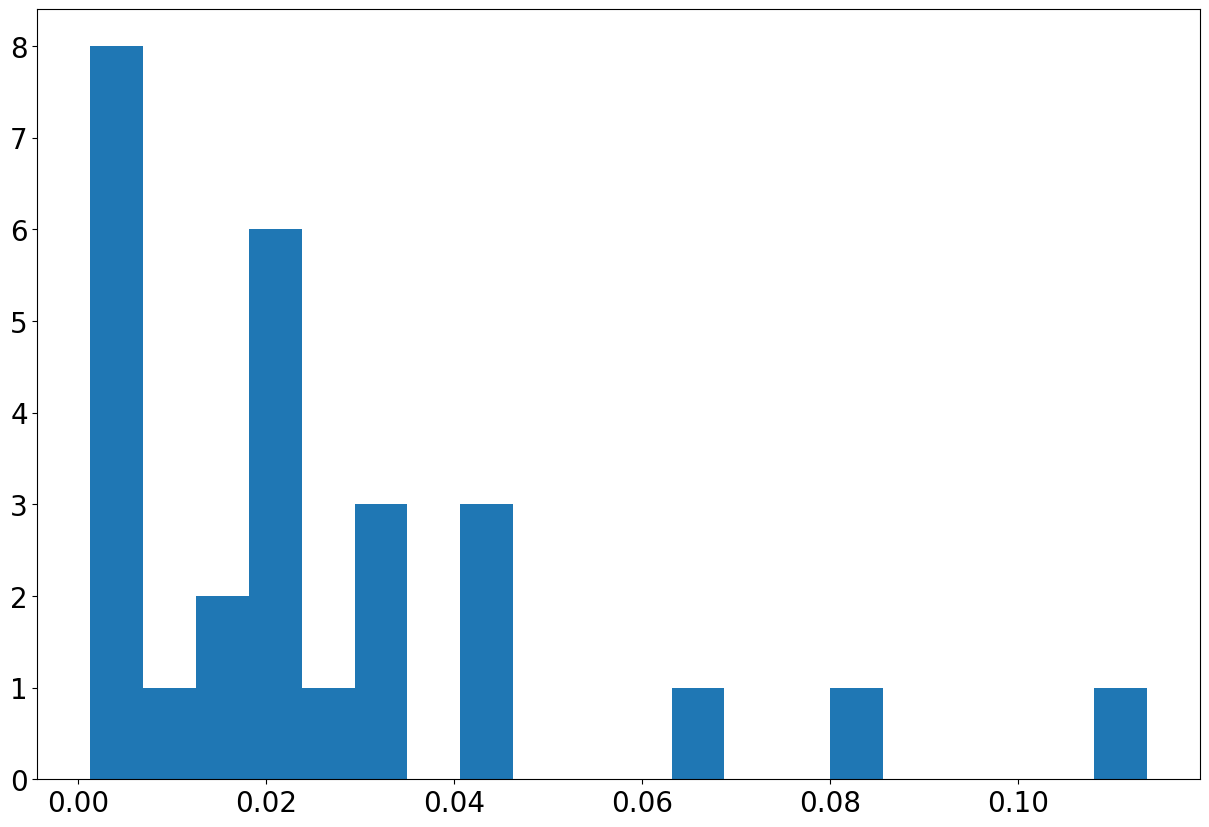

In [146]:
vals = []
for seq, ss, react in zip(row["sequence"], row["structure"], row["data"]):
    if seq == "G" or seq == "U":
        continue
    if ss == ".":
        vals.append(react)
plt.hist(vals, bins=20)

### UACGG_CCUAAG

In [89]:
df_UACGG_CCUAAG = df_mttr6_full[df_mttr6_full["name"] == "UACGG_CCUAAG"]

(0.0, 0.04)

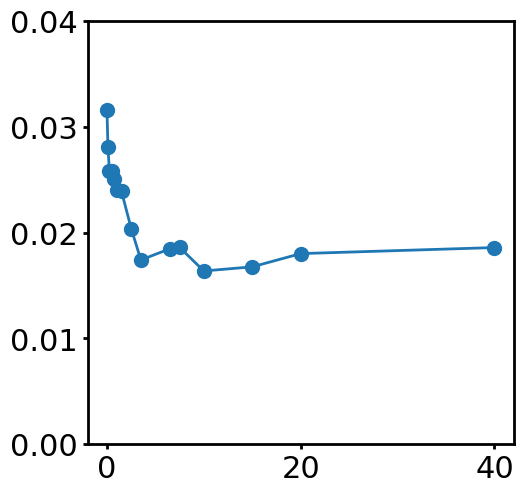

In [90]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
POS = 9
publication_style_ax(ax)
publication_line(ax, df_UACGG_CCUAAG['mg_conc'], df_UACGG_CCUAAG['tlr'].apply(lambda x : x[POS-1]), marker='o')
ax.set_ylim(0,0.04)

In [91]:
df_m_0 = df_UACGG_CCUAAG[df_UACGG_CCUAAG["mg_conc"] == 0.0]
df_m_40 = df_UACGG_CCUAAG[df_UACGG_CCUAAG["mg_conc"] == 40.0]

In [92]:
# note make sure to get the correct flanking pairs from the full sequence
ss = SequenceStructure("AAUACGG&CCUAAGUU", "(((..((&))...)))")


In [93]:
data_m_0 = get_dms_reactivity_for_sub_structure(df_m_0, ss)
data_m_40 = get_dms_reactivity_for_sub_structure(df_m_40, ss)

In [94]:
row_m_0 = df_m_0.iloc[0]
row_m_40 = df_m_40.iloc[0]

In [95]:
full_data_m_0 = row_m_0['gaaa'] + data_m_0[0]
full_data_m_40 = row_m_40['gaaa'] + data_m_40[0]

In [96]:
generate_pymol_file(full_data_m_0, "UACGG_CCUAAG_mg_0.dat")
generate_pymol_file(full_data_m_40, "UACGG_CCUAAG_mg_40.dat")

### UAUGG_CCUAAAG

In [97]:
df_AUAUGG_CCUAAAGU = df_mttr6_full[df_mttr6_full["name"] == "UAUGG_CCUAAAG"]

In [98]:
data = get_dms_reactivity_for_sub_structure(df_m_40, ss)

(0.0, 0.04)

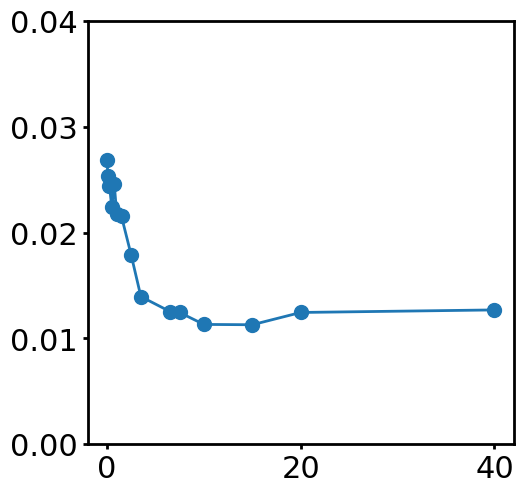

In [99]:
fig, ax = plt.subplots(figsize=(5.5, 5.5))
POS = 6
publication_style_ax(ax)
publication_line(ax, df_AUAUGG_CCUAAAGU['mg_conc'], df_AUAUGG_CCUAAAGU['tlr'].apply(lambda x : x[POS-1]), marker='o')
ax.set_ylim(0,0.04)

In [100]:
df_m_0 = df_AUAUGG_CCUAAAGU[df_AUAUGG_CCUAAAGU["mg_conc"] == 0.0]
df_m_40 = df_AUAUGG_CCUAAAGU[df_AUAUGG_CCUAAAGU["mg_conc"] == 40.0]

In [101]:
# note make sure to get the correct flanking pairs from the full sequence
ss = SequenceStructure("UAUAUGG&CCUAAAGUA", "(((..((&))....)))")


In [102]:
data_m_0 = get_dms_reactivity_for_sub_structure(df_m_0, ss)
data_m_40 = get_dms_reactivity_for_sub_structure(df_m_40, ss)

In [103]:
row_m_0 = df_m_0.iloc[0]
row_m_40 = df_m_40.iloc[0]

In [104]:
full_data_m_0 = row_m_0['gaaa'] + data_m_0[0]
full_data_m_40 = row_m_40['gaaa'] + data_m_40[0]

In [105]:
generate_pymol_file(full_data_m_0, "AUAUGG_CCUAAAGU_mg_0.dat")
generate_pymol_file(full_data_m_40, "AUAUGG_CCUAAAGU_mg_40.dat")